# COVID-19 Auswertung - new cases, deaths, Intensivstationen
## DIVI und WHO Daten - Deutschland und einige Nachbarn


## import libraries

In [38]:
version = "V0.2.0" # 04.01.2021 - Time Series Impffdaten erstellen

In [39]:
# DATAFRAMES
# data (WHO-data)
# df_divi2 (DIVI)
# df_PQ (Positivenquote)
# df_EW (Einwohner)
# df_I (Impfquote)
# df_I_EW (Impfqoute UND Einwohner)
# d (df_performance_Führungskreis.csv)

In [40]:
import pandas as pd #Daten
from matplotlib import pyplot as plt # plots
#import matplotlib as mpl
from matplotlib.ticker import FuncFormatter   # Numberformat plot ticks
import numpy as np

# performance
from datetime import datetime
from datetime import date # todays date
import seaborn as sns

import os
now = datetime.now()

# Preprocessing Dataframes

In [41]:
today = date.today().strftime("%d.%m.%Y")

## Datenimport

In [42]:
# Webabruf - CSV einlesen
data = pd.read_csv("https://covid19.who.int/WHO-COVID-19-global-data.csv")

# Lokal - CSV einlesen
df_divi2 = pd.read_csv("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\data-k3LbD.csv")
df_divi2['date'] = pd.to_datetime(df_divi2.date, utc=True)
#df_divi2 = df.loc[df.date >= ts, :]

# Datenimport Positivenquote
df_PQ = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Testzahlen-gesamt.xlsx",
                    sheet_name ="Testzahlen",
                    usecols="B:F",
                    skiprows=2,)

# Datenimport Einwohnerdaten Bundesländer
df_EW = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\02-bundeslaender.xlsx",
                     sheet_name="Bundesländer_mit_Hauptstädten",
                     usecols="A:G",
                     skiprows=6)


# Impfungen sheet_name der Datenquelle auslesen
df_I_sheet = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx", None)
sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
sheet_name = [*sheet_name][1]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen


# Datenimport Impfungen
df_I = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx",
                    sheet_name = sheet_name,
                    usecols="A:G")

## preprocessing

### data (WHO)

In [43]:
#gleitender Mittelwert der cases und deaths, 7 Tage
data['MA'] = data['New_cases'].rolling(window=7,min_periods=1).mean()
data['MA_deaths'] = data['New_deaths'].rolling(window=7, min_periods=1).mean()

data['MSTD_cases'] = data['New_cases'].rolling(window=7,min_periods=1).std()
data['MSTD_deaths'] = data['New_deaths'].rolling(window=7,min_periods=1).std()

data['OTG_cases'] = data['MA'] + data['MSTD_cases']
data['UTG_cases'] = data['MA'] - data['MSTD_cases']

data['OTG_deaths'] = data['MA_deaths'] + data['MSTD_deaths']
data['UTG_deaths'] = data['MA_deaths'] - data['MSTD_deaths']

# Date_reported in eine Datumsspalte umwandeln
data['Date_reported'] = pd.to_datetime(data.Date_reported, utc=True)

#Timestamp definieren  YYYY-MM-DD
ts = pd.to_datetime('2020-10-01', utc=True)

# Zeit eingrenzen
data = data.loc[data.Date_reported >= ts, :]

data = data.drop(columns=['Country_code', 'WHO_region', 'Cumulative_cases', 'Cumulative_deaths'])

data.head(1)

,Date_reported,Country,New_cases,New_deaths,MA,MA_deaths,MSTD_cases,MSTD_deaths,OTG_cases,UTG_cases,OTG_deaths,UTG_deaths
272,2020-10-01 00:00:00+00:00,Afghanistan,17,0,16.428571,1.0,8.96023,1.290994,25.388801,7.468342,2.290994,-0.290994


### df_divi2 (DIVI)

In [44]:
# Zeit eingrenzen

df_divi2 = df_divi2.loc[df_divi2.date >= ts, :]
#df_divi2.head(1)

In [45]:
# preprocessing Positivenquote
df_PQ = df_PQ.drop(columns=['Anzahl übermittelnde Labore', 'Positiven-quote (%)'])
df_PQ = df_PQ.replace('\*','',regex=True)
df_PQ.drop(df_PQ.tail(2).index,inplace=True) # drop last n rows
df_PQ.drop(df_PQ.head(1).index,inplace=True) # drop last n rows
#df_PQ["Positiven-quote (%)"] = df_PQ["Positiven-quote (%)"].astype(str)+ " %"
df_PQ["Kalenderwoche 2020"] = "KW "+df_PQ["Kalenderwoche 2020"].astype(str)

df_PQ["Positivenquote"] = round(100*(df_PQ["Positiv getestet"]/df_PQ["Anzahl Testungen"]),1)
#df_PQ.head(1)

### df_EW (Einwohnerdaten pro Bundesland)

In [46]:
# Spalten Überschriften definieren 
df_EW.rename(columns= {"Unnamed: 0": "Bundesland"},inplace=True)
df_EW.rename(columns= {"Unnamed: 1": "Stadt"},inplace=True)
df_EW.rename(columns= {"Unnamed: 2": "Fläche"},inplace=True)
df_EW.rename(columns= {"Unnamed: 3": "Einwohner"},inplace=True)
df_EW.rename(columns= {"Unnamed: 4": "Einwohner_M"},inplace=True)
df_EW.rename(columns= {"Unnamed: 5": "Einwohner_F"},inplace=True)
df_EW.rename(columns= {"Unnamed: 6": "Einwohner_pro_km²"},inplace=True)

# nicht gebrauchte columns löschen
df_EW = df_EW.drop(columns=['Stadt','Einwohner_M','Einwohner_F','Einwohner_pro_km²'])

# Rechnen
df_EW["Einwohner_pro_km²"] = df_EW["Einwohner"]/df_EW["Fläche"]

# alles löschen was keine Bundesländer sind
df_EW["Bundesland"] = df_EW["Bundesland"].fillna("x")      # ersetze alle NaN Werte mit x
df_EW["Fläche"] = df_EW["Fläche"].fillna("x")              # ersetze alle NaN Werte mit x
indexNames = df_EW[ df_EW['Bundesland'] == "x" ].index     # alle Index Werte mit "x" in eine Variable schreiben
df_EW.drop(indexNames , inplace=True)                      # lösche diese Index rows vom dataframe
indexNames = df_EW[ df_EW['Fläche'] == "x" ].index         # wiederholen
df_EW.drop(indexNames , inplace=True)                      # wiederholen


# Bundesland erste 3 Zeichen entfernen
df_EW["Bundesland"] = df_EW["Bundesland"].str[3:]

# Datentyp in float ändern
df_EW["Fläche"] = pd.to_numeric(df_EW["Fläche"], errors='coerce')

#remove space at start
df_EW["Bundesland"] = df_EW["Bundesland"].str.lstrip()
#df_EW.head(1)

### df_I (Impfdaten pro Bundesland)

In [47]:
df_I.head(1)

,Bundesland,Impfungen kumulativ,Differenz zum Vortag,Impfungen pro 1.000 Einwohner,Indikation nach Alter*,Berufliche Indikation*,Medizinische Indikation*
0,Baden-Württemberg,27454.0,3390.0,2.473246,12584.0,8739.0,1469.0


In [48]:

# nicht gebrauchte columns löschen
df_I = df_I.drop(columns=['Indikation nach Alter*','Berufliche Indikation*','Medizinische Indikation*'])

# nicht gebrauchte rows löschen
df_I.drop([16,17,18,19] , inplace=True)

df_I["Differenz zum Vortag"] = df_I["Differenz zum Vortag"].fillna(0)

df_I.head(1)

,Bundesland,Impfungen kumulativ,Differenz zum Vortag,Impfungen pro 1.000 Einwohner
0,Baden-Württemberg,27454.0,3390.0,2.473246


### df_I_EW (Impfquote)

In [49]:
# #df_I_EW.head(1)

In [50]:
# Timeseries gestern einlesen
df_I_timeseries1 = pd.read_csv('D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_I_timeseries.csv')

In [51]:
# Impfquote in % pro Bundesland
# VLOOKUP 
df_I_EW = pd.merge(df_I, df_EW, on='Bundesland', how='outer')   # how='outer','inner','left','right'
df_I_EW["Impfquote [%]"] = (df_I_EW["Impfungen kumulativ"]/df_I_EW["Einwohner"])*100*(1/2)
del df_I_EW["Fläche"]
del df_I_EW["Einwohner"]
del df_I_EW["Einwohner_pro_km²"]
df_I_EW = df_I_EW.sort_values(by=['Impfquote [%]'], ascending=False)

### df_I_timeseries1 () 

In [52]:
# # hier ist noch eine Fehlermöglichkeit, wenn das Programm läuft ohne das neue Daten reinkommen 
# # Es muss noch abgefragt werden, ob die kumulierten impfungen größer sind als die im file 
# # sonst werden doppelte Datensätze erzeugt

# df_I_timeseries1 = pd.read_csv("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_I_timeseries.csv")

# df_I_timeseries1_last = df_I_timeseries1.iloc[[-1]]   # letzte Zeile des df
# z = df_I_timeseries1_last["Datum"].values[0]          # z dem Zelleninhalt zuweisen
# print(f'z = {z}')

# if z == today:
#     print("nichts appended")
# else:
#     print("append")
#     df_I_timeseries2 = df_I_EW
#     df_I_timeseries2["Datum"] = today
#     df_I_timeseries2 = df_I_timeseries2[['Datum', 
#                                          'Bundesland', 
#                                          'Impfungen kumulativ', 
#                                          'Differenz zum Vortag', 
#                                          'Impfquote [%]']]
#     df_I_timeseries1 = df_I_timeseries1.append(df_I_timeseries2, ignore_index=True)

### Einwohnerzahlen

In [53]:
E_fr = 66012908
E_pl = 38659927
E_ger = 83020000
E_cz = 10586651
E_at = 8902600
E_ch = 8847020
E_gb = 66650000

### Berechnung Herdeinimmunität

In [54]:

Impfstart = datetime.strptime('28.12.2020', '%d.%m.%Y')
Tage_seit_Impfstart = (now-Impfstart).days
Summe_Impfungen = df_I_EW["Impfungen kumulativ"].sum()
Impfgeschwindigkeit = (1/2)*Summe_Impfungen/Tage_seit_Impfstart
Impfgeschwindigkeit_gestern = (1/2)*df_I_EW["Differenz zum Vortag"].sum()

if Impfgeschwindigkeit_gestern > Impfgeschwindigkeit:
    Impfgeschwindigkeit = (Impfgeschwindigkeit*0.2 + Impfgeschwindigkeit_gestern*0.8)
    print(f'Impfgeschwindigkeit = {Impfgeschwindigkeit} IF-Statement')

Herdenimmun = round((1/12)*(1/30)*(E_ger*0.6)*(1/(Impfgeschwindigkeit)),1)   # grobe Schätzung Anzahl Monate bis Herdenimmun



print(f'Tage_seit_Impfstart = {Tage_seit_Impfstart}')   # wie lange schon geimpft wird
print(f'Summe_Impfungen = {Summe_Impfungen}')
print(f'Impfgeschwindigkeit = {Impfgeschwindigkeit} Mittelwert')
print(f'Impfgeschwindigkeit_gestern = {Impfgeschwindigkeit_gestern}')
print(f'E_ger = {E_ger}')   # Einwohner Deutschland
print(f'Herdenimmun = {Herdenimmun} Jahren')

Tage_seit_Impfstart = 8
Summe_Impfungen = 265986.0
Impfgeschwindigkeit = 16624.125 Mittelwert
Impfgeschwindigkeit_gestern = 11446.0
E_ger = 83020000
Herdenimmun = 8.3 Jahren


In [55]:
# v=s/t    v = 83020000*0.6 / t   t = 

Ende = datetime.strptime('01.10.2021', '%d.%m.%Y')
Tage_bis_Oktober = (Ende - now).days
print(f'Tage_bis_Oktober = {Tage_bis_Oktober} Tage')

Impfungen60 = 2*(E_ger*0.6 - Summe_Impfungen)
SOLL_Impfungen60 = int(Impfungen60*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen60 = {SOLL_Impfungen60} Impfungen pro Tag')

Impfungen30 = 2*(E_ger*0.3 - Summe_Impfungen)
SOLL_Impfungen30 = int(Impfungen30*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen30 = {SOLL_Impfungen30} Impfungen pro Tag')

Impfungen15 = 2*(E_ger*0.15 - Summe_Impfungen)
SOLL_Impfungen15 = int(Impfungen15*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen15 = {SOLL_Impfungen15} Impfungen pro Tag')

Impfungen5 = 2*(E_ger*0.05 - Summe_Impfungen)
SOLL_Impfungen5 = int(Impfungen5*(1/Tage_bis_Oktober))
print(f'SOLL_Impfungen5 = {SOLL_Impfungen5} Impfungen pro Tag')


Tage_bis_Oktober = 268 Tage
SOLL_Impfungen60 = 369746 Impfungen pro Tag
SOLL_Impfungen30 = 183880 Impfungen pro Tag
SOLL_Impfungen15 = 90947 Impfungen pro Tag
SOLL_Impfungen5 = 28992 Impfungen pro Tag


### Länder definieren

In [56]:
ger = data[data.Country == 'Germany']
fr = data[data.Country == 'France']
at = data[data.Country == 'Austria']
pl = data[data.Country == 'Poland']
cz = data[data.Country == 'Czechia']
ch = data[data.Country == 'Switzerland']
it = data[data.Country == 'Italy']
es = data[data.Country == 'Spain']
gb = data[data.Country == 'The United Kingdom']
se = data[data.Country == 'Sweden']

# Variablen für die Plots definieren

### Linien und Schriftgrößen

In [57]:
# Linien Stärke
lws = 3
lwb = 7
# Bezugsschriftgröße
size = 28

 ### Bezugsgröße Einwohner

In [58]:
pE = 100000

### Speicherorte und Dateinamen Plots

In [59]:
pfad = "D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\"

name_1_1 = "plot_1-1_cases_absolute numbers.png" # cases absoulte zahlen EU
name_1_2 = "plot_1-2_cases.png" # cases pro 100.000 Einwohner EU 
name_2 = "plot_2_intensiv.png" # intensiv Deutschland
name_2_2 = "plot_2_2_intensiv_gesamt.png" # intensiv Deutschland covid und nicht covid
name_2_3 = "plot_2_3_intensiv_covid-19.png" # intensiv Deutschland covid
name_3_1 = "plot_3-1_deaths_absolute numbers.png" # deaths absolute zahlen EU
name_3_2 = "plot_3-2_deaths.png" # deaths pro 100.000 Einwohner EU
name_4_1 = "plot_4-1_cases_ger.png" # cases Deutschland
name_4_2 = "plot_4-2_deaths_ger.png" # deaths Deutschland
name_5 = "performance_dist_plot.png" # Performance Plot
name_6 = "plot_6_Positivenquote_ger.png" # Positivenquote
name_6_2 = "plot_6-2_Anzahl_Testungen_ger.png" # Anzahl Testungen
name_7 = "plot_7_Impfquote_ger.png" # Impfquote Deutschland Bundesländer
name_7_2 = "plot_7-2_Impfungen_Timeseries_ger.png" # Impfungen Timeseries Deutschland

## Länder Farben

In [60]:
c_fr = '#f80d0d'    # rot
c_pl = '#25e5e5'    # cyan
c_ger = '#0721ff'   # dunkelblau
c_cz = '#bb8fce'    # lila
c_at = '#18c213'    # grün
c_ch = '#000000'    # schwarz
c_gb = '#faac2b'    # orange

# Visualisierung der Plots

### 1-1) Neue Fälle 7 Tage Mittelwert (absolute Zahlen)

In [61]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')

# Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 

plt.plot(gb.Date_reported,gb['MA'], color=c_gb, linestyle = 'dashed', linewidth = lws, label="Großbritannien")
plt.plot(ger.Date_reported,ger['MA'], color=c_ger, linestyle = 'solid', linewidth = lwb, label="Deutschland")
plt.plot(fr.Date_reported,fr['MA'], color=c_fr, linestyle = 'dashed', linewidth = lws, label="Frankreich")
plt.plot(pl.Date_reported,pl['MA'], color=c_pl, linestyle = 'dashed', linewidth = lws, label="Polen")
plt.plot(cz.Date_reported,cz['MA'], color=c_cz, linestyle = 'dashed', linewidth = lws, label="Tschechien")
plt.plot(ch.Date_reported,ch['MA'], color=c_ch, linestyle = 'dashed', linewidth = lws, label="Schweitz")
plt.plot(at.Date_reported,at['MA'], color=c_at, linestyle = 'dashed', linewidth = lws, label="Österreich")

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Neue Fälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Neue Fälle pro Tag - absolute Zahlen (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_1_1, dpi = 150, bbox_inches='tight')
plt.close()

### 1-2) Neue Fälle 7 Tage Mittelwert (pro 100.000 Einwohner)

In [62]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')


# Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 

plt.plot(cz.Date_reported,cz['MA']* (pE/E_cz), color=c_cz, linestyle = 'dashed', linewidth = lws, label="Tschechien")
plt.plot(gb.Date_reported,gb['MA']* (pE/E_gb), color=c_gb, linestyle = 'dashed', linewidth = lws, label="Großbritannien")
plt.plot(ch.Date_reported,ch['MA']* (pE/E_ch), color=c_ch, linestyle = 'dashed', linewidth = lws, label="Schweitz")
plt.plot(ger.Date_reported,ger['MA']* (pE/E_ger), color=c_ger, linestyle = 'solid', linewidth = lwb, label="Deutschland")
plt.plot(at.Date_reported,at['MA']* (pE/E_at), color=c_at, linestyle = 'dashed', linewidth = lws, label="Österreich")
plt.plot(pl.Date_reported,pl['MA']* (pE/E_pl), color=c_pl, linestyle = 'dashed', linewidth = lws, label="Polen")
plt.plot(fr.Date_reported,fr['MA']* (pE/E_fr), color=c_fr, linestyle = 'dashed', linewidth = lws, label="Frankreich")

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)


# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Neue Fälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Neue Fälle pro Tag - pro 100.000 Einwohner (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_1_2, dpi = 150, bbox_inches='tight')
plt.close()

### 2-2) Intensivstationen DIVI2

In [63]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)
plt.plot(df_divi2.date,df_divi2['Belegte Betten'], color = 'blue', linewidth = lws, label = "nicht-Covid-19")
plt.plot(df_divi2.date,df_divi2['COVID-19-Fälle'], color = 'red', linewidth = lws, label = "Covid-19")


plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)

# plt.xticks([])
plt.ylabel('Anzahl Personen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)
#plt.title('DIVI-Intensivregister (www.intensivregister.de)  \n Stand: ' + today, fontsize=size)

plt.title('Intensivstationen in Deutschland (DIVI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between 
plt.fill_between(df_divi2.date, df_divi2['COVID-19-Fälle'], color='red',alpha=0.5)
plt.fill_between(df_divi2.date, df_divi2['COVID-19-Fälle'], df_divi2['Belegte Betten'], color='blue',alpha=0.5)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_2_2, dpi = 150, bbox_inches='tight')
plt.close()

In [64]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)
#plt.plot(df_divi2.date,df_divi2['Belegte Betten'], color = 'blue', linewidth = lws, label = "nicht-Covid-19")
plt.plot(df_divi2.date,df_divi2['COVID-19-Fälle'], color = 'red', linewidth = lws, label = "Covid-19")


plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)

# plt.xticks([])
plt.ylabel('Anzahl Personen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)
#plt.title('DIVI-Intensivregister (www.intensivregister.de)  \n Stand: ' + today, fontsize=size)

plt.title('Intensivstationen in Deutschland (DIVI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between 
plt.fill_between(df_divi2.date, df_divi2['COVID-19-Fälle'], color='red',alpha=0.5)
#plt.fill_between(df_divi2.date, df_divi2['COVID-19-Fälle'], df_divi2['Belegte Betten'], color='blue',alpha=0.5)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_2_3, dpi = 150, bbox_inches='tight')
plt.close()

###  3-1) Todesfälle 7 Tage Mittelwert (absolute Zahlen) 

In [65]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)

# Todesfälle pro 100.000 Einwohner 02.12.2020
plt.plot(ger.Date_reported,ger['MA_deaths'], color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland") # blau, linie, dick
plt.plot(gb.Date_reported,gb['MA_deaths'], color=c_gb, linestyle = 'dashed', linewidth = lws, label = "Großbritannien") # gelb, gestrichelt, dünn
plt.plot(fr.Date_reported,fr['MA_deaths'], color=c_fr, linestyle = 'dashed', linewidth = lws, label = "Frankreich") # rot, gestrichelt, dünn
plt.plot(pl.Date_reported,pl['MA_deaths'], color=c_pl, linestyle = 'dashed', linewidth = lws, label = "Polen") # cyan, gestrichelt, dünn
plt.plot(cz.Date_reported,cz['MA_deaths'], color=c_cz, linestyle = 'dashed', linewidth = lws, label = "Tschechien") # magenta, gestrichelt, dünn
plt.plot(at.Date_reported,at['MA_deaths'], color=c_at, linestyle = 'dashed', linewidth = lws, label = "Österreich") # grün, gestrichelt, dünn
plt.plot(ch.Date_reported,ch['MA_deaths'], color=c_ch, linestyle = 'dashed', linewidth = lws, label = "Schweitz") # schwarz, gestrichelt, dünn

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)
plt.ylabel('Todesfälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Todesfälle pro Tag - absolute Zahlen (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_3_1, dpi = 150, bbox_inches='tight')
plt.close()

###  3-2) Todesfälle 7 Tage Mittelwert (pro 100.000 Einwohner) 

In [66]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)

# Todesfälle pro 100.000 Einwohner 02.12.2020

plt.plot(cz.Date_reported,cz['MA_deaths'] * (pE/E_cz), color=c_cz, linestyle = 'dashed', linewidth = lws, label = "Tschechien") # magenta, gestrichelt, dünn
plt.plot(at.Date_reported,at['MA_deaths'] * (pE/E_at), color=c_at, linestyle = 'dashed', linewidth = lws, label = "Österreich") # grün, gestrichelt, dünn
plt.plot(gb.Date_reported,gb['MA_deaths'] * (pE/E_gb), color=c_gb, linestyle = 'dashed', linewidth = lws, label = "Großbritannien") # gelb, gestrichelt, dünn
plt.plot(ger.Date_reported,ger['MA_deaths'] * (pE/E_ger), color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland") # blau, linie, dick
plt.plot(ch.Date_reported,ch['MA_deaths'] * (pE/E_ch), color=c_ch, linestyle = 'dashed', linewidth = lws, label = "Schweitz") # schwarz, gestrichelt, dünn
plt.plot(pl.Date_reported,pl['MA_deaths'] * (pE/E_pl), color=c_pl, linestyle = 'dashed', linewidth = lws, label = "Polen") # cyan, gestrichelt, dünn
plt.plot(fr.Date_reported,fr['MA_deaths'] * (pE/E_fr), color=c_fr, linestyle = 'dashed', linewidth = lws, label = "Frankreich") # rot, gestrichelt, dünn


# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)
plt.ylabel('Todesfälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Todesfälle pro Tag - pro 100.000 Einwohner (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_3_2, dpi = 150, bbox_inches='tight')
plt.close()

In [67]:
# ts = pd.to_datetime('2020-12-15', utc=True)
# #dataframe reduzieren 
# data = data.loc[data.Date_reported >= ts, :]
# ger = data[data.Country == 'Germany']

###  4-1) Cases 7 Tage Mittelwert Deutschland

In [68]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

# Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 
plt.plot(ger.Date_reported,ger['MA'], color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland\n(7-Tage Mittel)")
plt.plot(ger.Date_reported,ger['New_cases'], marker='.', linestyle='', color=c_ger, markersize = 20)
plt.plot(ger.Date_reported,ger['OTG_cases'], color='red', linestyle = 'dashed', linewidth = lws, label ="+1 sigma")
plt.plot(ger.Date_reported,ger['UTG_cases'], color='red', linestyle = 'dashed', linewidth = lws, label ="-1 sigma")

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=3, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)

plt.ylabel('Neue Fälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Neue Fälle pro Tag - Deutschland (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between lines
plt.fill_between(ger.Date_reported, ger['OTG_cases'], ger['UTG_cases'] , color='red',alpha=0.5)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_4_1, dpi = 150, bbox_inches='tight')
plt.close()

###  4-2) Deaths 7 Tage Mittelwert Deutschland

In [69]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)

# Todesfälle pro 100.000 Einwohner 02.12.2020

plt.plot(ger.Date_reported,ger['MA_deaths'], color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland\n(7-Tage Mittel)") # blau, linie, dick
plt.plot(ger.Date_reported,ger['New_deaths'], marker='.', linestyle='', color=c_ger, markersize = 20)

plt.plot(ger.Date_reported,ger['OTG_deaths'], color='red', linestyle = 'dashed', linewidth = lws, label ="+1 sigma")
plt.plot(ger.Date_reported,ger['UTG_deaths'], color='red', linestyle = 'dashed', linewidth = lws, label ="-1 sigma")

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=3, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)
plt.ylabel('Todesfälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Todesfälle pro Tag - Deutschland (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between lines
plt.fill_between(ger.Date_reported, ger['OTG_deaths'], ger['UTG_deaths'] , color='red',alpha=0.5)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_4_2, dpi = 150, bbox_inches='tight')
plt.close()

In [70]:
#df_PQ.head(1)

In [71]:
y = max(df_PQ["Positivenquote"])*0.96
print(f'y = {y}')

x=(1/2)*df_PQ["Kalenderwoche 2020"].count()
print(f'x = {x}')


y = 12.48
x = 21.0


## RKI Positivenquote pro Woche

In [72]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')

plt.bar(x=df_PQ["Kalenderwoche 2020"], height=df_PQ["Positivenquote"], width = 0.9, align = 'center', color = c_ger)

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 15, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Positivenquote in %', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Positivenquote - Deutschland (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


plt.text(x, y, r'Positivenquote =  $\frac{Positive\ Tests}{Anzahl\ Tests}\cdot100$', horizontalalignment='center', size=size-4, style='italic',
        bbox={'facecolor': c_ger, 'alpha': 0.5, 'pad': 5})

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_6, dpi = 150, bbox_inches='tight')

plt.close()

## RKI Testungen pro Woche

In [73]:
#df_PQ.head(1)

In [74]:
def millions(x, pos):
   # 'The two args are the value and tick position'
    return '%1.1f Mio' % (x * 1e-6)
formatter = FuncFormatter(millions)


fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
ax.yaxis.set_major_formatter(formatter)


ax = plt.bar(x=df_PQ["Kalenderwoche 2020"], height=df_PQ["Anzahl Testungen"], width = 0.9, align = 'center', color = c_ger)

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 15, rotation=90)
plt.yticks(fontsize=size -4)


plt.ylabel('Anzahl Testungen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Anzahl Testungen (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

#plt.figure(figsize=(16,9))

fig.savefig(pfad + name_6_2, dpi = 150, bbox_inches='tight')

plt.close()

In [75]:
x = (1/2)*df_I_EW["Bundesland"].count()
y = max(df_I_EW["Impfquote [%]"])*0.93
print(x)
print(y)

8.0
0.3323539397738254


## Impfquote - Bundesländer 

In [76]:
plt.figure(figsize=(16,9))

plt.style.use('seaborn')

plt.bar(x=df_I_EW["Bundesland"], height=df_I_EW["Impfquote [%]"], width = 0.9, align = 'center', color = c_ger)

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Impfquote [%]', fontsize=size)
plt.xlabel('Bundesland', fontsize=size)

plt.title('Impfquote - Deutschland (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

plt.text(x, y, f'grobe Hochrechnung: 60% der Bevölkerung geimpft in \nca. {Herdenimmun} Jahren.', 
        horizontalalignment='center', 
        size=size-4, 
        style='italic',
        bbox={'facecolor': c_ger, 'alpha': 0.5, 'pad': 5})

# plt.text(x, y*0.89, r'Impfquote =  $\frac{1}{2}\cdot\frac{Impfungen}{Einwohner}\cdot100$', 
#         horizontalalignment='center', 
#         size=size-4, 
#         style='italic',
#         bbox={'facecolor': c_ger, 'alpha': 0.5, 'pad': 5})

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_7, dpi = 150, bbox_inches='tight')

plt.close()

## RKI - Impfungen Timeseries

In [77]:
# Impfungen sheet_name der Datenquelle auslesen
df_I_sheet = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx", None)
sheet_name = df_I_sheet.keys()         # Tabellenblätter Namen auslesen
sheet_name = [*sheet_name][2]          # Namen des zweiten Tabellenblattes anzeigen [*dict] dict keyword->list Index 1 anzeigen

# Datenimport Impfungen
df_I_TS = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx",
                    sheet_name = sheet_name,
                    usecols="A:B")

df_I_TS.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_I_TS_RKI.csv', index=False)


#gleitender Mittelwert der cases und deaths, 7 Tage
df_I_TS['MA'] = df_I_TS['Gesamtzahl Impfungen'].rolling(window=7,min_periods=1).mean()

df_I_TS['MSTD_Impfungen'] = df_I_TS['Gesamtzahl Impfungen'].rolling(window=7,min_periods=1).std()

df_I_TS['OTG_Impfungen'] = df_I_TS['MA'] + df_I_TS['MSTD_Impfungen']
df_I_TS['UTG_Impfungen'] = df_I_TS['MA'] - df_I_TS['MSTD_Impfungen']

df_I_TS['SOLL_Impfungen60'] = SOLL_Impfungen60
df_I_TS['SOLL_Impfungen30'] = SOLL_Impfungen30
df_I_TS['SOLL_Impfungen15'] = SOLL_Impfungen15
df_I_TS['SOLL_Impfungen5'] = SOLL_Impfungen5

# Date_reported in eine Datumsspalte umwandeln
data['Datum der Impfung'] = pd.to_datetime(data.Date_reported, utc=True)
df_I_TS.head(1)

,Datum der Impfung,Gesamtzahl Impfungen,MA,MSTD_Impfungen,OTG_Impfungen,UTG_Impfungen,SOLL_Impfungen60,SOLL_Impfungen30,SOLL_Impfungen15,SOLL_Impfungen5
0,2020-12-27,23224,23224.0,NaN,NaN,NaN,369746,183880,90947,28992


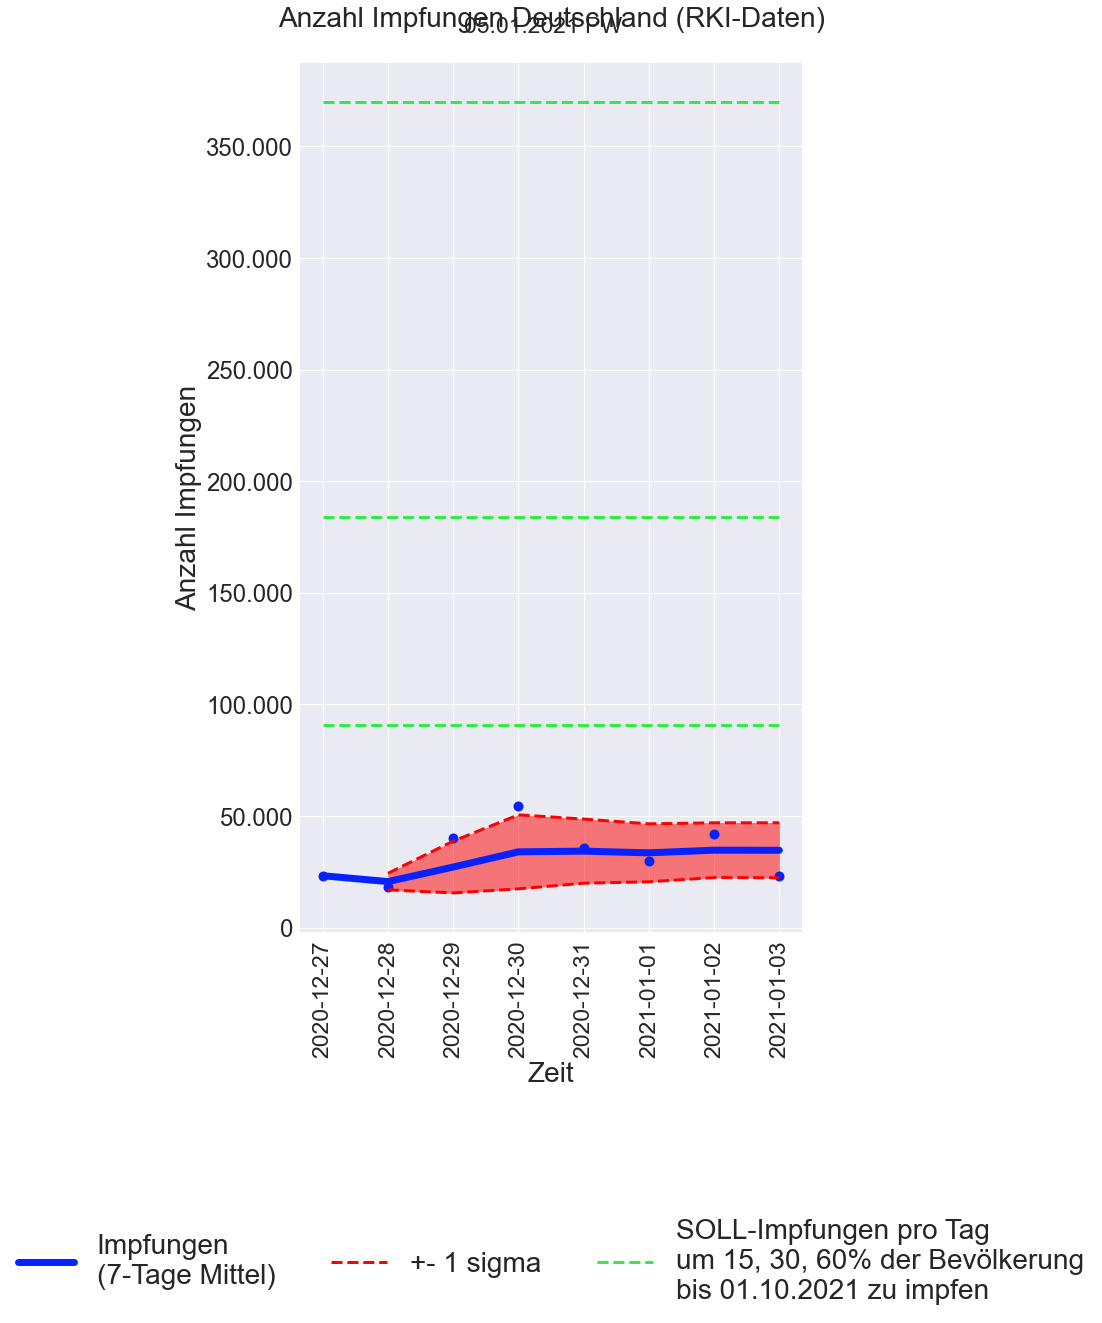

In [78]:

def y_axis_thousands(x, pos):
   # 'The two args are the value and tick position'
    return '{:0,d}'.format(int(x)).replace(",",".")
formatter = FuncFormatter(y_axis_thousands)


fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot()
ax.yaxis.set_major_formatter(formatter)


ax1 = plt.plot(df_I_TS['Datum der Impfung'],df_I_TS['MA'], color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Impfungen\n(7-Tage Mittel)") # blau, linie, dick
ax2 = plt.plot(df_I_TS['Datum der Impfung'],df_I_TS['Gesamtzahl Impfungen'], marker='.', linestyle='', color=c_ger, markersize = 20)

ax3 = plt.plot(df_I_TS['Datum der Impfung'],df_I_TS['OTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, label ="+- 1 sigma")
ax4 = plt.plot(df_I_TS['Datum der Impfung'],df_I_TS['UTG_Impfungen'], color='red', linestyle = 'dashed', linewidth = lws, label ="")

ax5 = plt.plot(df_I_TS['Datum der Impfung'],
               df_I_TS['SOLL_Impfungen60'], 
               color='#34eb46', 
               linestyle = 'dashed', 
               linewidth = lws, 
               label = "SOLL-Impfungen pro Tag\num 15, 30, 60% der Bevölkerung\nbis 01.10.2021 zu impfen")

ax6 = plt.plot(df_I_TS['Datum der Impfung'],
               df_I_TS['SOLL_Impfungen30'], 
               color='#34eb46', 
               linestyle = 'dashed', 
               linewidth = lws, 
               label = "")

ax7 = plt.plot(df_I_TS['Datum der Impfung'],
               df_I_TS['SOLL_Impfungen15'], 
               color='#34eb46', 
               linestyle = 'dashed', 
               linewidth = lws, 
               label = "")

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 5, rotation=90)
plt.yticks(fontsize=size - 4)


plt.ylabel('Anzahl Impfungen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Anzahl Impfungen Deutschland (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


# # fill area between lines
plt.fill_between(df_I_TS['Datum der Impfung'], df_I_TS['OTG_Impfungen'], df_I_TS['UTG_Impfungen'] , color='red',alpha=0.5)



# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=3, 
           fontsize=size)


fig.savefig(pfad + name_7_2, dpi = 150, bbox_inches='tight')

# plt.close()
plt.show()



## RKI Ausbruchdaten

In [79]:
# # Daten einlesen Excel - Ausbruchsdaten
# df_AB = pd.read_excel("D:\Github\Covid-19-Auswertung-WHO-DIVI\Data\Ausbruchsdaten.xlsx;jsessionid=F348B3B6878DF2812C1DF10FACEB13F4.xlsx",
#                      sheet_name ="Ausbruch_MW_D_ab2Faelle")
# #                       usecols=,
# #                       skiprows=,
# df_AB.head(1)

## RKI Altersdaten

In [80]:
#df_AB["Meldewoche"].tail(1)

## dataframes speichern

In [81]:
data.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\data_WHO_data.csv', index=False)
df_divi2.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_divi2.csv', index=False)
df_PQ.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_PQ.csv', index=False)
df_EW.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_EW.csv', index=False)
df_I.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_I.csv', index=False)
df_I_EW.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_I_EW.csv', index=False)
df_I_TS.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_I_TS.csv', index=False)

## Performance messen

In [82]:
pc = os.environ['COMPUTERNAME']
now2 = datetime.now()

# Laufzeit
x = now2 - now
x = round(x.total_seconds(),2)

# Performance CSV einlesen
d = pd.read_csv('D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_performance_Führungskreis.csv')

# Neues Dateframe für die Performance definieren
now = datetime.now()

d2 = {'Date': [now],
      'PC': [pc],
      'Laufzeit_in_s': [x],
      'Version': [version]}
#d2

# Datum Spalte formatieren
df2 = pd.DataFrame(d2)
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d %r')

# Performance mit dem CSV verbinden
d = d.append(df2, ignore_index=True)

# Datenexport Performance
d.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\Dataframes\\df_performance_Führungskreis.csv', index=False)

# Plot Performance
sns.set(rc={'figure.figsize':(16,9)})
sns_plot = sns.distplot(d['Laufzeit_in_s'],
            kde=True,
            rug=True,
            )
sns_plot.set_title('Performance distribution',size=size)
sns_plot.set_ylabel('Wahrscheinlichkeit', size = size -5)
sns_plot.set_xlabel('Laufzeit [s]', size = size -5)
fig = sns_plot.get_figure()
fig.savefig(pfad + name_5) 
plt.close()
print(f'performance {pc} = {x} seconds')

performance DOUG = 6.04 seconds
